## Assignment 3

#### Akshay Santoshi - CS21BTECH11012
#### Nitya Bhamidipaty - CS21BTECH11041 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

In [2]:
df = pd.read_csv("data.csv")
df.head()

,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
0,0.997797,0.999888,0.215934,0.196713,0.000000,0.955616,0.998810,-0.032581,1.761759,-0.054329
1,0.994004,0.979902,-0.337135,-0.248634,0.000000,0.640812,0.553918,-0.032026,-0.629311,-0.053516
2,0.947603,0.455667,0.001743,0.128610,-0.004054,-0.162069,0.960601,-0.030209,1.535697,-0.054215
3,0.396577,0.919933,0.496451,0.576824,-0.340718,0.802363,0.673710,-0.032058,0.449160,-0.054126
4,0.999893,0.327615,0.700477,0.315601,0.000000,0.300785,0.979009,-0.032224,1.762049,-0.054330


In [3]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

In [4]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(16)
        )
        self.mu = nn.Linear(16, latent_dim)
        self.log_var = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(16),
            nn.Linear(16, 32),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, input_dim)
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        enc = self.encoder(x)
        mu, log_var = self.mu(enc), self.log_var(enc)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

    def sample(self, n_samples):
        with torch.no_grad():
            z = torch.randn(n_samples, latent_dim)
            return self.decoder(z).numpy()

Epoch 0, Loss: 1.7347
Epoch 50, Loss: 0.8792
Epoch 99, Loss: 0.8305
Epoch 0, Loss: 1.2930
Epoch 50, Loss: 0.8086
Epoch 99, Loss: 0.7296
Epoch 0, Loss: 1.4223
Epoch 50, Loss: 0.8986
Epoch 99, Loss: 0.7659
Epoch 0, Loss: 1.3967
Epoch 50, Loss: 0.8136
Epoch 99, Loss: 0.6992


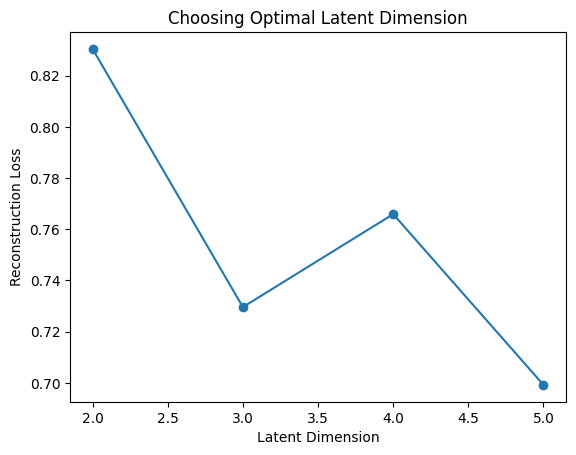

In [5]:
latent_dims = [2, 3, 4, 5]  
reconstruction_losses = []
epochs_num = 100

for latent_dim in latent_dims:
    vae = VAE(input_dim=data_scaled.shape[1], latent_dim=latent_dim)  
    optimizer = optim.Adam(vae.parameters(), lr=0.001)
    # optimizer = optim.AdamW(vae.parameters(), lr=0.001, weight_decay=1e-5)
    loss_fn = nn.MSELoss()
    # loss_fn = nn.SmoothL1Loss()

    for epoch in range(epochs_num):  
        x = torch.tensor(data_scaled, dtype=torch.float32)
        optimizer.zero_grad()
        x_recon, mu, log_var = vae(x)
        recon_loss = loss_fn(x_recon, x)
        beta = min(0.1 + 0.01 * epoch, 0.5)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + beta * kl_loss
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0 or epoch==epochs_num-1:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    reconstruction_losses.append(loss.item())

plt.plot(latent_dims, reconstruction_losses, marker='o', linestyle='-')
plt.xlabel("Latent Dimension")
plt.ylabel("Reconstruction Loss")
plt.title("Choosing Optimal Latent Dimension")
plt.show()


In [6]:
# Training VAE
input_dim = data_scaled.shape[1]
latent_dim = 5  # From checking, I got 5 to be the better latent dimension.
vae = VAE(input_dim, latent_dim)
# optimizer = optim.AdamW(vae.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
# loss_fn = nn.SmoothL1Loss()
loss_fn = nn.MSELoss()

In [7]:
def train_vae(epochs=epochs_num):
    vae.train()
    for epoch in range(epochs):
        x = torch.tensor(data_scaled, dtype=torch.float32)
        optimizer.zero_grad()
        x_recon, mu, log_var = vae(x)
        recon_loss = loss_fn(x_recon, x)
        beta = min(0.1 + 0.01 * epoch, 0.5)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + 0.1 * kl_loss 
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0 or epoch == epochs-1:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [8]:
train_vae(epochs=400)

Epoch 0, Loss: 1.5445
Epoch 50, Loss: 0.5860
Epoch 100, Loss: 0.4546
Epoch 150, Loss: 0.3828
Epoch 200, Loss: 0.3267
Epoch 250, Loss: 0.2936
Epoch 300, Loss: 0.2647
Epoch 350, Loss: 0.2454
Epoch 399, Loss: 0.2291


In [9]:
# Get Latent Representations
vae.eval()
x = torch.tensor(data_scaled, dtype=torch.float32)
_, mu, _ = vae(x)
latent_data = mu.detach().numpy()

In [10]:
# Elbow Method to Determine k
from kneed import KneeLocator

inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(latent_data)
    inertia.append(kmeans.inertia_)

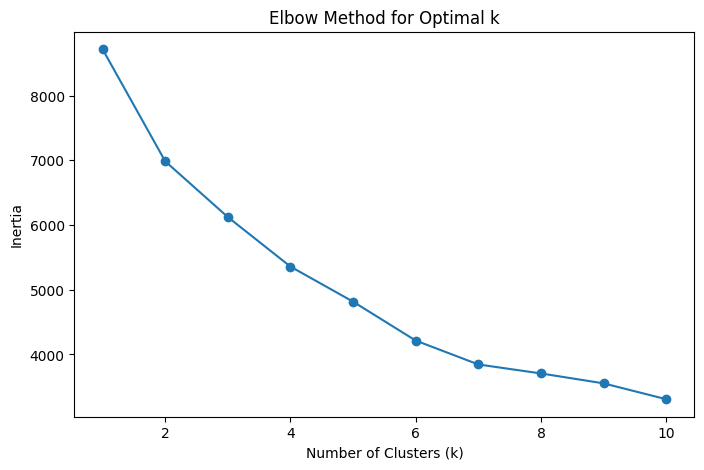

Optimal k found: 6


In [11]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

knee_locator = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow
print(f"Optimal k found: {optimal_k}")

In [12]:
# Apply K-Means
# optimal_k = 6  # From above checking, I got 6 to be the better number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(latent_data)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [13]:
# Identifying the outliers:
# Small clusters have been considered as those which have their size less than 50.
# For big clusters, we have taken boundary points as those which are outside 95% away from the cluster's center.

clusters, counts = np.unique(labels, return_counts=True)

print("Cluster Sizes:")
for cluster, count in zip(clusters, counts):
    print(f"Cluster {cluster}: {count} points")

small_clusters = clusters[counts < 50]

boundary_points = []
small_cluster_points = []

for i, label in enumerate(labels):
    if label in small_clusters:
        small_cluster_points.append(i)  
    else:
        point_dist = np.linalg.norm(latent_data[i] - cluster_centers[label])
        all_dists = np.linalg.norm(latent_data[labels == label] - cluster_centers[label], axis=1)
        
        # Boundary points: Points which are outside 95% of the distance
        if point_dist > np.percentile(all_dists, 95):
            boundary_points.append(i)  

# print("Boundary Points Row Numbers:", boundary_points)
# print("Small Cluster Points Row Numbers:", small_cluster_points)

Cluster Sizes:
Cluster 0: 234 points
Cluster 1: 121 points
Cluster 2: 208 points
Cluster 3: 126 points
Cluster 4: 247 points
Cluster 5: 263 points


In [14]:
boundary_df = df.iloc[boundary_points]
small_cluster_df = df.iloc[small_cluster_points]

print("\n=== Boundary Points from big clusters ===")
print(boundary_df.to_string(index=True))

print("\n=== Small Cluster Points ===")
print(small_cluster_df.to_string(index=True))


=== Boundary Points from big clusters ===
          cov1      cov2      cov3      cov4      cov5      cov6      cov7  sal_pur_rat  igst_itc_tot_itc_rat  lib_igst_itc_rat
2     0.947603  0.455667  0.001743  0.128610 -0.004054 -0.162069  0.960601    -0.030209              1.535697         -0.054215
5     0.595378 -0.531958  0.679654 -0.126799  0.455487  0.432046  0.988092    -0.029813              0.768742         -0.054167
13    0.825371 -0.248244  0.220238  0.128478  0.383093  0.364443  0.951265    -0.030247              1.512327         -0.054221
18    0.948575  0.464917  0.366662  0.515506  0.064824 -0.192308  0.997203    -0.031555              1.838233         -0.054304
25    0.310202  0.714827  0.999397  0.450586  0.999196  0.951493  0.994530     3.957174             -0.567733         -0.042841
45    0.188614  0.031166  0.832167  0.342503 -0.153480  0.824574  0.152444    -0.013936             -0.296467         -0.052397
53    0.999971  0.801451  0.450078  0.296673 -0.671271  0.221